# 1. Data

Подгрузим все нобходимые для работы с данными библиотеки:

In [1]:
import warnings
import numpy as np
import pandas as pd
# Инструменты для построения графиков
import matplotlib.pyplot as plt
import seaborn as sns
# Инструменты для предобработки данных
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures
# Инструменты для создания выборки и модели
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Инструменты для анализа метрик, полученных при обучении на наших данных
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve
# Инструменты для работы с датами
from datetime import datetime
from sklearn.model_selection import GridSearchCV
# Подгрузка данных, с которыми мы будем работать
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
# отключим отображение ошибок
warnings.filterwarnings("ignore")

Для начала подгрузим данные:

In [2]:
# загрузка данных
df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

Сохраним настройки и Random seed для воспроизводимости эксперементов:

In [3]:
!pip freeze > requirements.txt
RANDOM_SEED = 45

Мы не будем соединять тестовый и обучающий фреймы в 1 во избежании обучения на тестовых данных. Все манипуляции с данными будут проходить параллельно

## 1.1. Описание полей
* client_id - идентификатор клиента
* education - уровень образования
* sex - пол заемщика
* age - возраст заемщика
* car - флаг наличия автомобиля
* car_type - наличие автомобиля иномарки
* deсline_app_cnt - количество отказанных прошлых заявок
* good_work - наличие хорошей работы
* bki_request_cnt - количество запросов в БКИ
* home_address - категоризатор домашнего адреса
* work_address - категоризатор рабочего адреса
* income - доход заемщика
* foreign_passport - наличие загранпаспорта
* sna - связь заемщика с клиентами банка
* first_time - давность наличия информации о заемщике
* score_bki - скоринговый балл по данным из БКИ
* region_rating - рейтинг региона
* app_date - дата подачи заявки
* default - Присутствие\отсутствие дефолта по кредиту

## 1.2. Проверка первичных данных

In [4]:
# Проверка стартовых данных
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


In [5]:
test_df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N


Поля выборок идентичны, главное различие - в обучающем фрейме присутствует целевой столбец 'default'.
Теперь взглянем на данные более подробно:

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [7]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

Из информации по дата-сетам получаем еще одно подтверждение, что поля выборок одинаковые.
При более подробном рассмотрении становится видно, что в выборках имеются пропуски. Посмотрим сколько их и в каких столбцах:

In [8]:
df.isnull().sum()

client_id             0
app_date              0
education           307
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
default               0
dtype: int64

In [9]:
test_df.isnull().sum()

client_id             0
app_date              0
education           171
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
dtype: int64

Пропусков немного и все они находятся в графе "education". По-хорошему, стоило бы данные удалить, т.к. сильного влияния это на общую выборку не окажет. Но мы попробуем в дальнейшем обработать пропуски и заполнить их выбранными значениями.

# 2. Preprocessing

Так как предобработку по пропущенным значениям требуется провести только со столбцом education, приступим непосредственно к анализу данных столбца.

## 2.1. Столбец education

Сам столбец отражает уровень образования того или клиента из имеющихся выборок. Посмотрим сколько предствалено различных типов образования:

In [10]:
# Посмотрим количество уникальных значений в выборке
df.education.nunique()

5

In [11]:
# Посмотрим какие это значения:
df.education.unique()

array(['SCH', 'GRD', 'UGR', 'PGR', 'ACD', nan], dtype=object)

Повторим для тестовой выборки:

In [12]:
print(test_df.education.nunique())
print(test_df.education.unique())

5
['GRD' 'SCH' 'UGR' 'PGR' nan 'ACD']


Значения одинаковые, что не может не радовать. В дальнейшем можно будет преобразовать либо при помощи OneHotEncoding либо через dummie-переменные.
Посмотрим распределение на гистограмме:

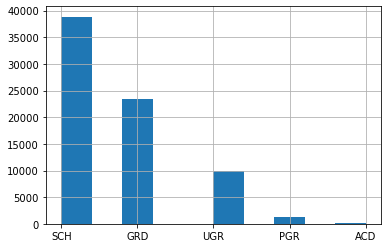

In [13]:
df.education.hist()

Из графика видно, что в выборке преобладает уровень образования SCH. Посмотрим, совпадает ли распределение учебной выборки с тестовой:

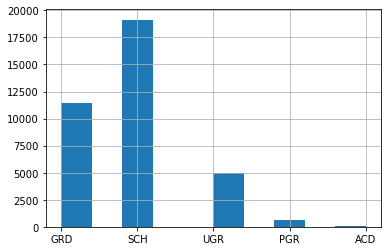

In [14]:
test_df.education.hist()

Распределения в выборках идентичны, поэтому для обеих выборок заменим пропуски значением моды:

In [15]:
# Заполняем значения NaN в выборках значением наиболее часто встречаемым в них(модой):
df.education = df.education.fillna(df['education'].mode()[0])
test_df.education = test_df.education.fillna(test_df['education'].mode()[0])

Проверим,заполнились ли пропущенные значения:

In [16]:
print(df.education.unique())
print(test_df.education.unique())

['SCH' 'GRD' 'UGR' 'PGR' 'ACD']
['GRD' 'SCH' 'UGR' 'PGR' 'ACD']


Как мы видим, более пропущенных значений в данном столбце обеих выборок не имеется

## 2.2. Прочие категориальные столбцы

Рассмотрим сразу все оставшиеся столбцы, для них нет необходимости заполнять пропущенные значения, так как они отсутствуют

In [17]:
# Список с названиями категориальных столбцов фрейма
cat_cols = ['education', 'home_address', 'work_address', 'sna', 'first_time']

Посмотрим количество уникальных значений для home_address и work_address:

In [18]:
df.home_address.value_counts()

2    39956
1    32585
3     1258
Name: home_address, dtype: int64

И сразу для тестовой выборки:

In [19]:
test_df.home_address.value_counts()

2    19635
1    16103
3      611
Name: home_address, dtype: int64

Теперь посмотрим на гистограммы:

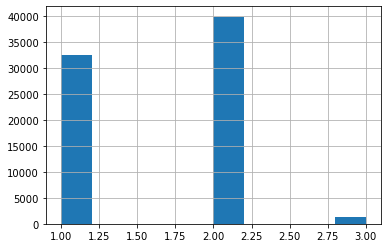

In [20]:
df.home_address.hist()

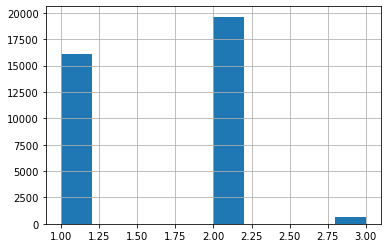

In [21]:
test_df.home_address.hist()

Как мы видим, представлено три типа адресов:1,2 и 3. Последний тип адресов выражен наименее ярко, их меньше всего. Вероятно, это может быть объяснено по принципу проживания (центр\окраина\пригород). Теперь посмотрим на work_address:

In [22]:
df.work_address.value_counts()

3    44959
2    20506
1     8334
Name: work_address, dtype: int64

In [23]:
test_df.work_address.value_counts()

3    22154
2    10255
1     3940
Name: work_address, dtype: int64

Теперь посмотрим гистограммы:

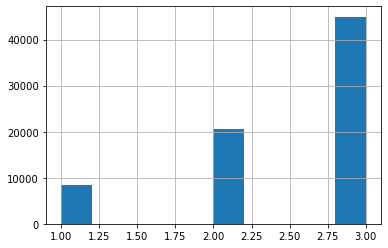

In [24]:
df.work_address.hist()

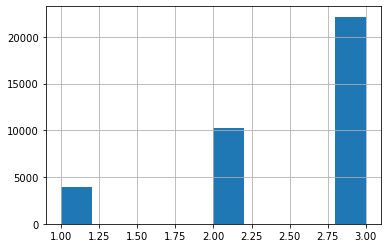

In [25]:
test_df.work_address.hist()

Здесь так же присутствует всего три типа обозначений, первый выражен наименее ярко. Вероятно это напрямую зависит от того, насколько далеко находится работа от дома.
В дальнейшем полученные признаки можно будет использовать для создания фич.

На основе просмотренных гистограмм можно сделать вывод, что каких-либо странных значений не присутствует, все значения находятся в удобоваримом диапазоне, чтобы можно было отнести их к нормальным. Графики домашнего адреса для обеих выборок имеют большее количество данных в середине и левой части, графики рабочего адреса смещен вправо.

Теперь посмотрим количество уникальных значений для столбца, отражающего взаимосвязь заемщика с клиентами банка:

In [26]:
print(df.sna.unique())
print(test_df.sna.unique())

[4 1 2 3]
[1 4 2 3]


Видно, что в обеих выборках варианты, которые могут принимать значения столбца - одинаковы, посмотрим на гистограммы

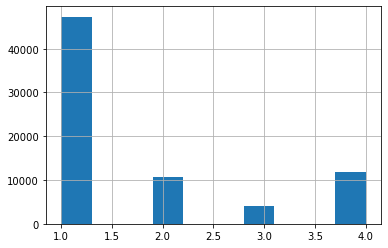

In [27]:
df.sna.hist()

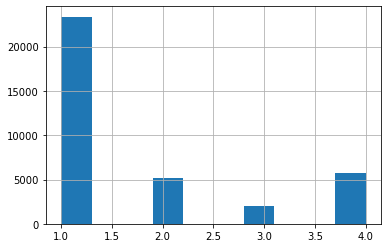

In [28]:
test_df.sna.hist()

Как и в предыдущих столбцах, распределение здесь похоже для тестовой и обучающей выборки, каких либо "странных" значений не наблюдается, все данные лежат в пределах нормы.

Рассмотрим столбец, который отражает давность информации о заемщике:

In [29]:
print(df.first_time.unique())
print(test_df.first_time.unique())

[1 4 3 2]
[4 3 1 2]


Теперь посмотрим, как значения столбца ведут себя на гистограммах:

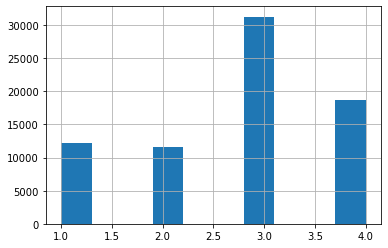

In [30]:
# Тренировочная выборка
df.first_time.hist()

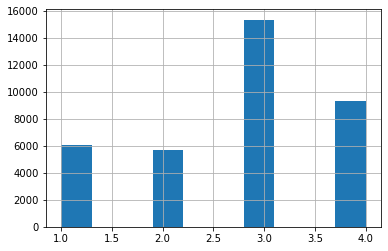

In [31]:
# Тестовая выборка
test_df.first_time.hist()

Как мы можем увидеть, значения столбца варьируются от 1 до 4. Вероятно, они отражают, имелись ли данные о клиенте до обращения. Принцип распределения значений, скорее всего,такой: 1 - новый заемщик, 4 - очень старый заемщик. 

Выбивающихся значений в выборках не наблюдается, наиболее явно выражено значение 3, распределение имеет более длинный хвост слева.

## 2.3. Бинарные столбцы

К бинарным столбцам можно отнести те, значения которых принимают только одно из двух значений, например "да" или "нет", "1" или "0" и т.д. В нашем фрейме к таким столбцам можно отнести следующие:

In [32]:
# Список с названиями бинарных столбцов фрейма
bin_cols = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work']

Посмотрим на уникальные значения:

In [33]:
print(df.sex.unique())
print(test_df.sex.unique())
print(df.car.unique())
print(test_df.car.unique())
print(df.car_type.unique())
print(test_df.car_type.unique())
print(df.foreign_passport.unique())
print(test_df.foreign_passport.unique())
print(df.good_work.unique())
print(test_df.good_work.unique())

['M' 'F']
['M' 'F']
['Y' 'N']
['Y' 'N']
['Y' 'N']
['Y' 'N']
['N' 'Y']
['N' 'Y']
[0 1]
[0 1]


Видно, что все столбцы имеют только 2 значения, аномальных значений и пропусков не наблюдается. Теперь проверим, как распределены значения этих столбцов:

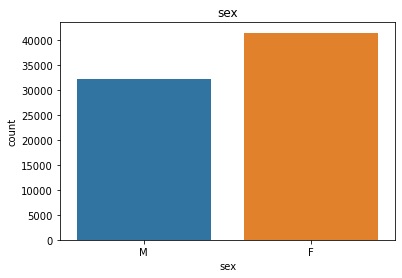

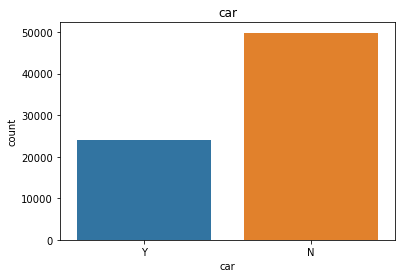

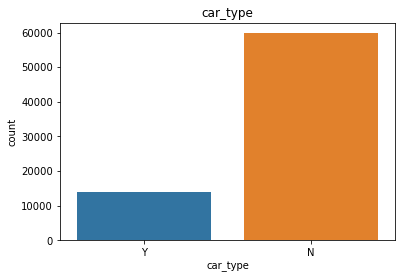

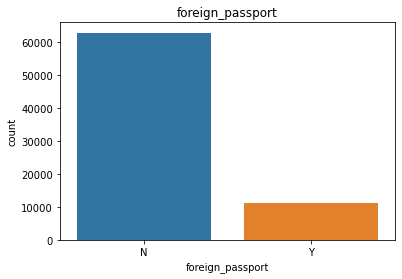

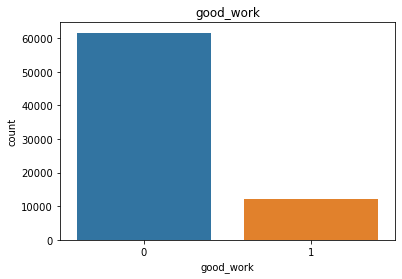

In [34]:
for column in bin_cols:
    plt.figure()
    sns.countplot(df[column])
    plt.title(column)
    plt.show()

На основе полученных гистограмм можно сделать вывод, что большинство классов неравномерны, возможно в дальнейшем придется их как-либо балансировать. Наиболее равным является столбец sex, количество людей обоих полов в выборке разнится не сильно. Теперь посмотрим как дела обстоят в тестовой выборке:

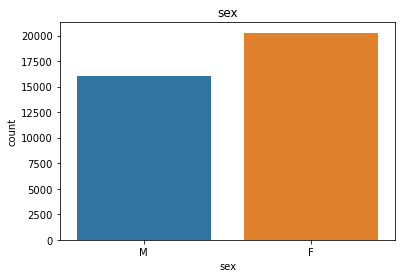

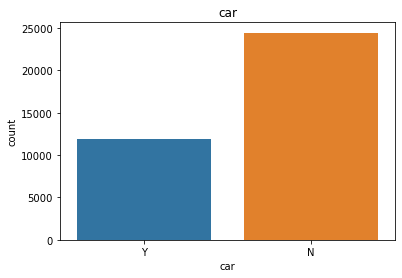

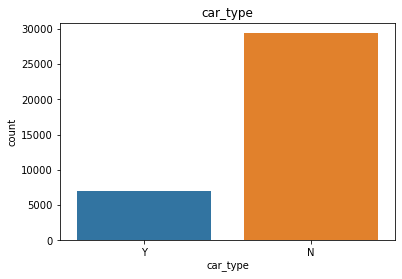

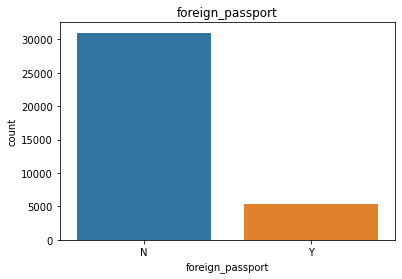

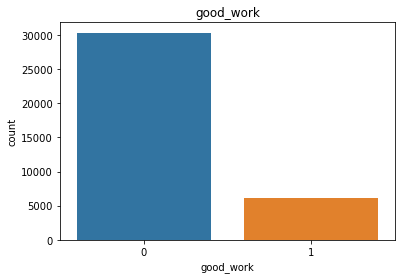

In [35]:
for column in bin_cols:
    plt.figure()
    sns.countplot(test_df[column])
    plt.title(column)
    plt.show()

Распределения выглядят примерно одинаково, соотношение классов похоже на обучающую выборку. В дальнейшем, возможно мы выделим новые фичи на основе уже имеющихся столбцов. Теперь можно перейти к числовым столбцам.

## 2.4. Числовые столбцы

Такие столбцы содержат те или иные значения, количество которых обычно довольно высоко. Конечно, часть бинарных столбцов тоже можно отнести к числовым, ведь они содержат 0 или 1, как значение. Но для бинарных столбцов это, скорее, является логической интерпритацией изначальных значений, поэтому их трогать не стоит. Рассмотрим столбцы более подробно:

In [36]:
# Список с названиями числовых столбцов фрейма
num_cols = ["age", "decline_app_cnt", "income",
            "bki_request_cnt", "score_bki", "region_rating"]

Так как различных значений в каждом из столбцов много, посмотрим сразу на гистограммы распределения значений:

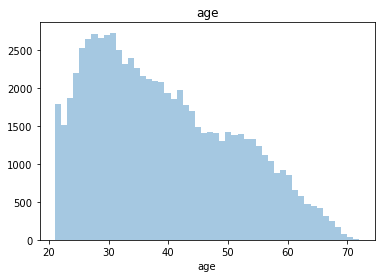

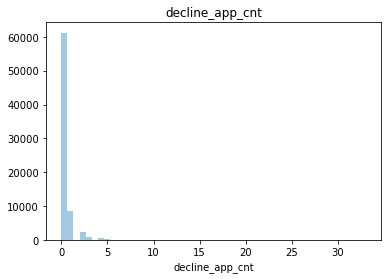

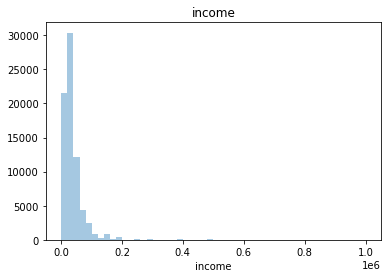

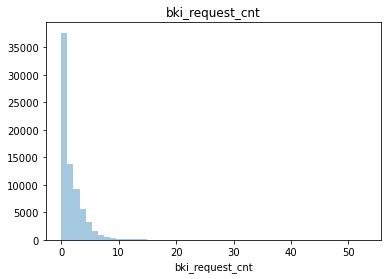

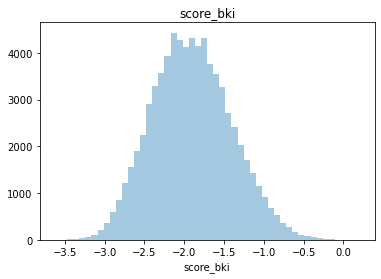

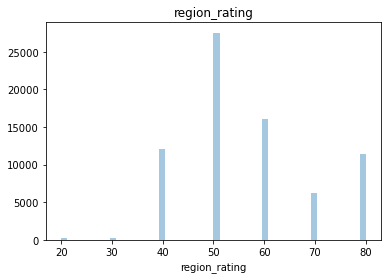

In [37]:
for col in num_cols:
    plt.figure()
    sns.distplot(df[col], kde=False, rug=False)
    plt.title(col)
    plt.show()

Теперь проверим для тестовой выборки:

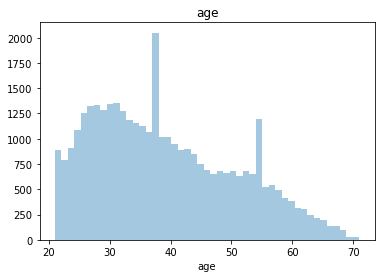

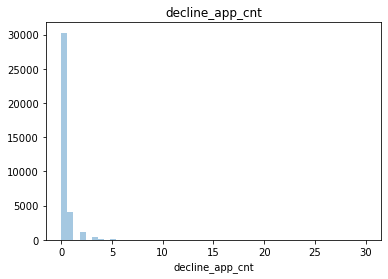

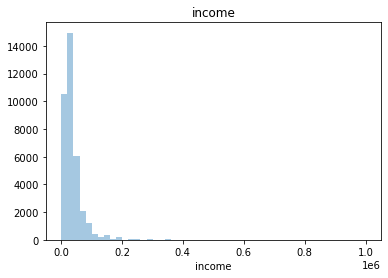

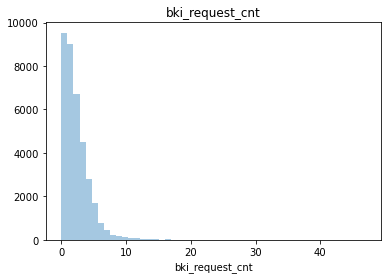

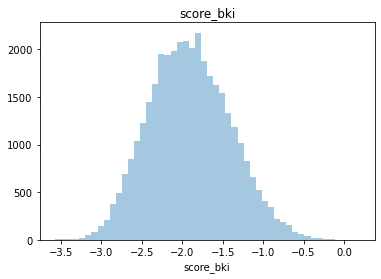

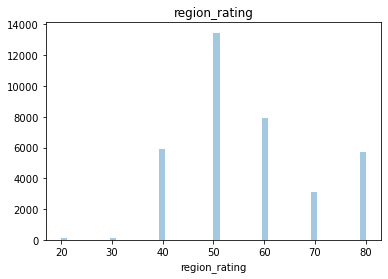

In [38]:
for col in num_cols:
    plt.figure()
    sns.distplot(test_df[col], kde=False, rug=False)
    plt.title(col)
    plt.show()

У тестовой выборки есть общая тенденция в распределении столбца age та же самая, что и у обучающей, но появились внезапные, выбивающиеся по количеству упоминаний, значения для людей старше 35 лет. Возможно для дальнейшего совершенствования модели, будет необходимо с этими данными что-то придумать.

На первый взгляд все графики выглядят нормально, без выбросов. По гистограмме распределения возраста можно сделать вывод, что молодые люди обращаются за кредитом чаще, чем взрослые(45+). Большая часть отказов по заявкам сосредоточена в районе 0. Это может говорить о том, что большая часть клиентов, по мнению банка, является добросовестной и стабильно выплачивает все деньги банку. Основная часть гистограммы дохода сосредоточена в районе минимальных значений, но есть и более высокие. Количество запросов в БКИ так же сосредоточено в районе минимальных значений, в особенности около 0-2 запросов, Само распределение смещено влево. Распределение score_bki является нормальным с центральной частью в районе -2. Рейтинг региона говорит нам о том, что большая часть обращающихся находится в регионах  со средним рейтингом, обращения из регионов с минимальным рейтингом почти отсутствует. 

Теперь проверим на выбросы при помощи IQR:

In [39]:
for col in num_cols:
    IQR = df[col].quantile(0.75) - df[col].quantile(0.25)
    perc25 = df[col].quantile(0.25)  # 25-й перцентиль
    perc75 = df[col].quantile(0.75)  # 75-й перцентиль

    print(
        f'Название столбца:{col} '
        '25-й перцентиль: {},'.format(perc25),
        '75-й перцентиль: {},'.format(perc75),
        "IQR: {}, ".format(IQR),
        "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR,
                                               l=perc75 + 1.5*IQR))

Название столбца:age 25-й перцентиль: 30.0, 75-й перцентиль: 48.0, IQR: 18.0,  Границы выбросов: [3.0, 75.0].
Название столбца:decline_app_cnt 25-й перцентиль: 0.0, 75-й перцентиль: 0.0, IQR: 0.0,  Границы выбросов: [0.0, 0.0].
Название столбца:income 25-й перцентиль: 20000.0, 75-й перцентиль: 48000.0, IQR: 28000.0,  Границы выбросов: [-22000.0, 90000.0].
Название столбца:bki_request_cnt 25-й перцентиль: 0.0, 75-й перцентиль: 3.0, IQR: 3.0,  Границы выбросов: [-4.5, 7.5].
Название столбца:score_bki 25-й перцентиль: -2.259533835, 75-й перцентиль: -1.56983126, IQR: 0.6897025750000001,  Границы выбросов: [-3.2940876975, -0.5352773974999998].
Название столбца:region_rating 25-й перцентиль: 50.0, 75-й перцентиль: 60.0, IQR: 10.0,  Границы выбросов: [35.0, 75.0].


Столбец age целиком и полностью лежит в допустимых границах, данные же столбца decline_app_cnt по IQR,похоже, слишком сильно сосредоточены в районе нуля, поэтому все остальное определяется как выброс. Здравый же смысл нам говорит, что действительно существуют люди, которым могут отказывать в заявке по 10-20 раз или, возможно, больше. Таких значений очень мало и сильного влияния они оказывать на результат не должны. Однако, если в дальнейшем метрики модели будут сильно неудобоваримы, мы можем как-либо заменить (медианой или модой) выбивающиеся значения. Посмотрим столбец income:

In [40]:
df.income[df.income > 90000].count()

4695

Как мы видим, для столбца income имеются значения, сильно выходящие за максимальную границу выброса согласно IQR. При этом, там присутствуют и значения, которые выходят даже за 400000. Исходя из метода, мы должны придумать, что делать со всеми значениями выше верхней границы выброса, но здравый смысл подсказывает, что за кредитами могут обращаться и люди, которые могут иметь свое личное дело. Т.е. доход которых может действительно принимать такие большие значения. Поэтому столбец оставим без изменения, однако будем иметь ввиду, что в случае дальнейшей корректировки модели, сильно выбивающиеся данные можно заменить либо максимальным или медианным значением, либо определить с помощью прочих методов. Посмотрим оставшиеся столбцы:

In [41]:
print(df.bki_request_cnt[df.bki_request_cnt > 7.5].count())
print(df.score_bki[df.score_bki < -3.2940876975].count())
print(df.score_bki[df.score_bki > -0.5352773975].count())

1755
52
299


Значения bki_request_cnt выбиваются за границы IQR не сильно, людей которые отправили заявок больше, чем того допускает IQR <1% от обучающей выборки. А более 15 заявок отправило менее 200 человек. Один человек отправил целых 53(!) заявки. Опять же, если в дальнейшем прогнозы модели будут плохими, можно будет заменить на значение медианы данного столбца. Для score_bki выбросы вообще не существенны,их очень мало и они не сильно удалены от границ IQR. Здесь преобразовывать ничего не будем.

Посмотрим, как ведет себя в этом плане тестовая выборка:

In [42]:
for col in num_cols:
    IQR = test_df[col].quantile(0.75) - test_df[col].quantile(0.25)
    perc25 = test_df[col].quantile(0.25)  # 25-й перцентиль
    perc75 = test_df[col].quantile(0.75)  # 75-й перцентиль

    print(
        f'Название столбца:{col} '
        '25-й перцентиль: {},'.format(perc25),
        '75-й перцентиль: {},'.format(perc75),
        "IQR: {}, ".format(IQR),
        "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR,
                                               l=perc75 + 1.5*IQR))

Название столбца:age 25-й перцентиль: 30.0, 75-й перцентиль: 48.0, IQR: 18.0,  Границы выбросов: [3.0, 75.0].
Название столбца:decline_app_cnt 25-й перцентиль: 0.0, 75-й перцентиль: 0.0, IQR: 0.0,  Границы выбросов: [0.0, 0.0].
Название столбца:income 25-й перцентиль: 20000.0, 75-й перцентиль: 48000.0, IQR: 28000.0,  Границы выбросов: [-22000.0, 90000.0].
Название столбца:bki_request_cnt 25-й перцентиль: 0.0, 75-й перцентиль: 3.0, IQR: 3.0,  Границы выбросов: [-4.5, 7.5].
Название столбца:score_bki 25-й перцентиль: -2.26190903, 75-й перцентиль: -1.56395672, IQR: 0.69795231,  Границы выбросов: [-3.308837495, -0.5170282549999998].
Название столбца:region_rating 25-й перцентиль: 50.0, 75-й перцентиль: 60.0, IQR: 10.0,  Границы выбросов: [35.0, 75.0].


В целом, общее поведение примерно одинаково. Если оценка модели будет плохой,необходимо будет заменить выбивающиеся значения на,например, медиану.

Также, мы упускаем из поля зрения столбец с датой заявки. Приведем его к стандартному формату:

In [43]:
# Приводим к типу отображения YYYY-MM-DD
df['app_date'] = df['app_date'].apply(lambda x: datetime.strptime(x, '%d%b%Y'))

Проведем ту же процедуру для тестовой выборки:

In [44]:
# Приводим к типу отображения YYYY-MM-DD
test_df['app_date'] = test_df['app_date'].apply(
    lambda x: datetime.strptime(x, '%d%b%Y'))

Теперь посмотрим на гистграммах распределение дат в выборках:

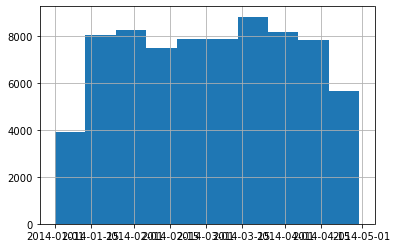

In [45]:
df.app_date.hist()

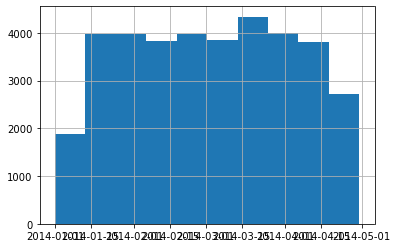

In [46]:
test_df.app_date.hist()

Распределение дат нормальное, четко выраженных пиков нет. Данный столбец тоже является числовым, на основе него можно будет выделить новые признаки.

Теперь осталось посмотреть на последний столбец: client_id. В целом, никакой смысловой нагрузки столбец нести не должен, проверим сколько уникальных значений:

In [47]:
print(df.client_id.nunique())
print(test_df.client_id.nunique())

73799
36349


Все значения,представленные в данном столбце уникальны. Большой значимости он для нас не имеет, поэтому переходим к другим столбцам.

Осталось посмотреть на целевой столбец и можно приступать к дальнейшей обработке данных и выделению фич.

## 2.5. Целевой столбец default

Целевой столбец представляет собой бинарное обозначение по перечню имеющихся клиентов обучающей выборки. На основе его значений будет проводиться валидация модели и последующий тест. Посмотрим распределение значений:

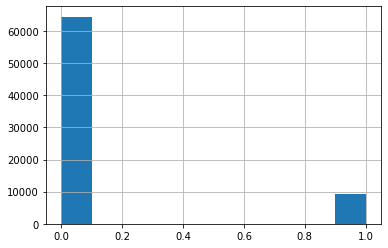

In [48]:
df.default.hist()

Как мы видим всего в выборке преобладает количество клиентов, вероятность дефолта для которых равна 0. Из-за этого выборка получается несбалансированной. Было бы неплохо воспользоваться либо oversampling'ом либо undersampling'ом, но я боюсь, что тогда модель может получить неполную информацию для будущих предсказаний. Поэтому попробуем посмотреть результат на модели с регуляризацией. В остальном - странных, выбивающихся из диапазона, значений не наблюдается. Теперь можно приступать к обработке столбцов и выделению новых значений.

# 3. Data Engeneering

Теперь попробуем выделить новые значения на основе уже имеющихся. Сначала посмотрим корреляцию Пирсона для имеющихся у нас данных:

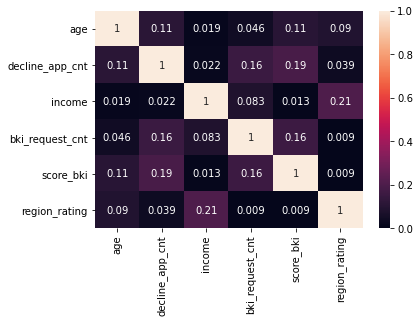

In [49]:
sns.heatmap(df[num_cols].corr().abs(), vmin=0, vmax=1, annot=True)

Как мы видим, сильной корреляции у признаков не наблюдается. Теперь перейдем к формированию новых столбцов.

## 3.1. Столбец app_date

На основе данного столбца можно сформировать столбец, который будет отображать "давность" заявки. Конечно, они все сосредоточены в одном году, но признак может оказаться значимым.

In [50]:
# Создаем переменную с текущей датой
current_date = datetime.now()

In [51]:
# Создаем столбец, который будет хранить разницу в днях между текущей датой и датой заявки
df['app_age'] = df['app_date'].apply(lambda x: (current_date-x).days)

Теперь посмотрим, что получилось:

In [52]:
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,app_age
0,25905,2014-02-01,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0,2677
1,63161,2014-03-12,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0,2638
2,25887,2014-02-01,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0,2677
3,16222,2014-01-23,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0,2686
4,101655,2014-04-18,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0,2601


Повторим для тестовой выборки:

In [53]:
test_df['app_age'] = test_df['app_date'].apply(lambda x: (current_date-x).days)

Посмотрим распределение значений app_age и добавим к списку числовых столбцов

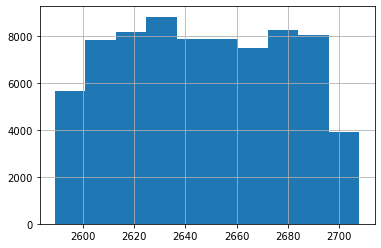

In [54]:
# Обучающая выборка
df.app_age.hist()

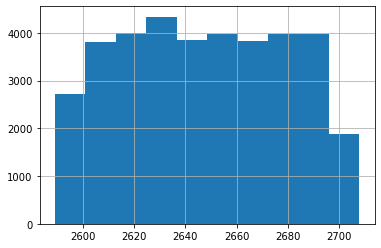

In [55]:
# Тестовая выборка
test_df.app_age.hist()

Как мы видим они полностью повторяют распределение самого столбца app_date, что логично. Теперь добавим к числовым столбцам:

In [56]:
num_cols.append('app_age')

После того, как список num_cols стал полностью сформирован, необходимо прологарифмировать признаки, которые вызывали вопросы:

In [57]:
num_cols

['age',
 'decline_app_cnt',
 'income',
 'bki_request_cnt',
 'score_bki',
 'region_rating',
 'app_age']

In [58]:
# создаем список столбцов, которые стоит логарифмировать.
num_cols_log = ['age', 'decline_app_cnt',
                'bki_request_cnt', 'income', 'app_age']
for col in num_cols_log:
    df[col] = np.log(df[col] + 1)

Теперь повторим для тестовой выборки:

In [59]:
for col in num_cols_log:
    test_df[col] = np.log(test_df[col] + 1)

Наконец, посмотрим на значимость полученных числовых признаков:

Text(0.5, 1.0, 'Значимость числовых признаков')

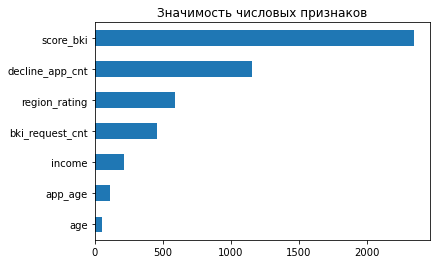

In [60]:
imp_num = pd.Series(f_classif(df[num_cols], df['default'])[0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')
plt.title('Значимость числовых признаков')

Как мы можем увидеть, наименее значимым из всех числовых признаков являетя возраст, а наиболее влиятельными - количество отказов по прошлым заявкам и скоринговый балл БКИ. Еще раз проверим корреляцию:

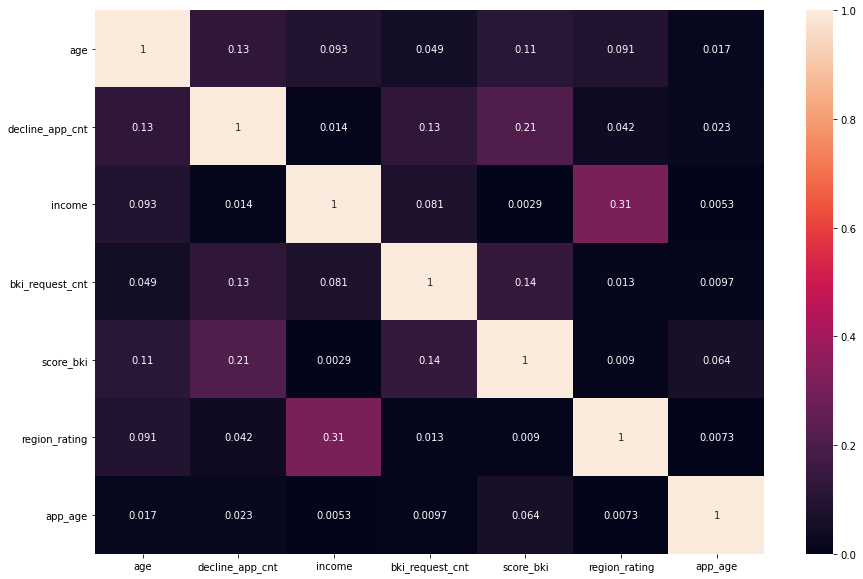

In [61]:
plt.figure(figsize=(15, 10))
sns.heatmap(df[num_cols].corr().abs(), vmin=0, vmax=1, annot=True)

Корреляционная зависимость по отношению к новому признаку мала.

## 3.2. Бинарные столбцы

Преобразуем бинарные столбцы так, чтобы в них находились только числовые значения:

In [62]:
label_encoder = LabelEncoder()
for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])
    test_df[column] = label_encoder.fit_transform(test_df[column])
    # на каждой итерации выводим результат, чтобы было понятно какие значения и на что мы заменили
    print(column, dict(enumerate(label_encoder.classes_)))

sex {0: 'F', 1: 'M'}
car {0: 'N', 1: 'Y'}
car_type {0: 'N', 1: 'Y'}
foreign_passport {0: 'N', 1: 'Y'}
good_work {0: 0, 1: 1}


Посмотрим, как теперь выглядит наш фрейм:

In [63]:
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,app_age
0,25905,2014-02-01,SCH,1,4.143135,1,1,0.000000,0,-2.008753,0.693147,50,1,2,9.798183,4,1,0,0,7.892826
1,63161,2014-03-12,SCH,0,4.094345,0,0,0.000000,0,-1.532276,1.386294,50,2,3,9.852247,4,1,0,0,7.878155
2,25887,2014-02-01,SCH,1,3.258097,1,0,1.098612,0,-1.408142,0.693147,80,1,2,10.308986,1,4,1,0,7.892826
3,16222,2014-01-23,SCH,0,3.988984,0,0,0.000000,0,-2.057471,1.098612,50,2,3,9.210440,1,3,0,0,7.896181
4,101655,2014-04-18,GRD,1,3.891820,0,0,0.000000,1,-1.244723,0.693147,60,2,3,10.308986,1,4,1,0,7.864036


Теперь преобразуем столбцы car и car_type в единый столбец, который будет отражать наличие машины, и если она есть - показывать, импортная она или нет.

In [64]:
# создаем список, в котором будут храниться значения
cars = []
# проверяем, есть машина или нет, и ставим соответствующую
# категорию в новый список
for i in df.car.index:
    if df.car[i] == 0:
        cars.append(0)
    elif df.car_type[i] == 0:
        cars.append(1)
    else:
        cars.append(2)

In [65]:
# Переносим полученные значения в новый столбец
df['car_and_brand'] = pd.Series(cars)
df.car_and_brand.value_counts()

0    49832
2    14008
1     9959
Name: car_and_brand, dtype: int64

Как мы видим, получился категориальный признак, который отражает наличие машины у клиента, и относит к одному из трех типов:
* клиент не имеет машины (0)
* клиент имеет отечественный автомобиль(1)
* клиент имеет импортный автомобиль(2)

Повторим для тестовой выборки

In [66]:
# создаем список, в котором будут храниться значения
cars_test = []
# проверяем, есть машина или нет, и ставим соответствующую
# категорию в новый список
for i in test_df.car.index:
    if test_df.car[i] == 0:
        cars_test.append(0)
    elif test_df.car_type[i] == 0:
        cars_test.append(1)
    else:
        cars_test.append(2)

In [67]:
# Переносим полученные значения в новый столбец
test_df['car_and_brand'] = pd.Series(cars_test)
test_df.car_and_brand.value_counts()

0    24458
2     7000
1     4891
Name: car_and_brand, dtype: int64

Добавим полученный признак к категориальным:

In [68]:
cat_cols.append('car_and_brand')

Теперь удалим исходные столбцы, на основе которых мы получили новый признак:

In [69]:
# удалим два исходных бинарных столбца, из которых мы получили
# категориальный столбец car_and_brand
bin_cols.remove('car')
bin_cols.remove('car_type')

Теперь создадим бинарный признак, который будет показывать - выше среднего доход у заемщика или нет.

In [70]:
df['income_level'] = df.income.apply(
    lambda x: 1 if x > df.income.mean() else 0)

In [71]:
test_df['income_level'] = test_df.income.apply(
    lambda x: 1 if x > df.income.mean()else 0)

Здесь мы сравниваем со средним значением заработка обучающей выборки, чтобы не получить разницы в масштабе. Посмотрим, как ведет себя распределение значений полученного признака:

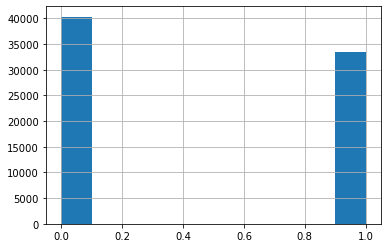

In [72]:
df.income_level.hist()

Из гистограммы видно, что доход выше среднего примерно у трети людей из всей обучающей выборки, что может говорить нам о тех, кто в основном обращается за кредитом. Добавим полученный столбец к бинарным:

In [73]:
bin_cols.append('income_level')

In [74]:
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,home_address,work_address,income,sna,first_time,foreign_passport,default,app_age,car_and_brand,income_level
0,25905,2014-02-01,SCH,1,4.143135,1,1,0.000000,0,-2.008753,...,1,2,9.798183,4,1,0,0,7.892826,2,0
1,63161,2014-03-12,SCH,0,4.094345,0,0,0.000000,0,-1.532276,...,2,3,9.852247,4,1,0,0,7.878155,0,0
2,25887,2014-02-01,SCH,1,3.258097,1,0,1.098612,0,-1.408142,...,1,2,10.308986,1,4,1,0,7.892826,1,0
3,16222,2014-01-23,SCH,0,3.988984,0,0,0.000000,0,-2.057471,...,2,3,9.210440,1,3,0,0,7.896181,0,0
4,101655,2014-04-18,GRD,1,3.891820,0,0,0.000000,1,-1.244723,...,2,3,10.308986,1,4,1,0,7.864036,0,0


Посмотрим значимость бинарных признаков нашей выборки:

Text(0.5, 1.0, 'Значимость бинарных признаков')

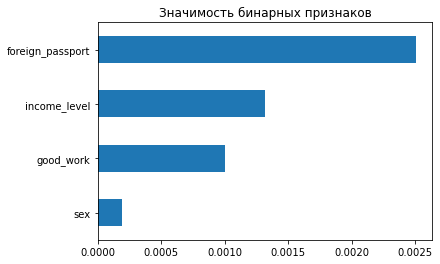

In [75]:
imp_bin = pd.Series(mutual_info_classif(df[bin_cols], df['default'],
                                        discrete_features=True), index=bin_cols)
imp_bin.sort_values(inplace=True)
imp_bin.plot(kind='barh')
plt.title('Значимость бинарных признаков')

Как видно из графика, наиболее влиятельными являются наличие иностранного паспорта и уровень дохода. Пол является наименее значимым из всех выделенных признаков.

## 3.3. Категориальные столбцы

Для этих столбцов мы применим OneHotEncoding, но для начала проверим, какие столбцы у нас отнесены к категориальным:

In [76]:
display(cat_cols)

['education',
 'home_address',
 'work_address',
 'sna',
 'first_time',
 'car_and_brand']

Для того,чтобы посмотреть значимость категориальных признаков, необходимо отразить столбец education при помощи dummie-переменных:

In [77]:
dummies_edu = pd.get_dummies(df['education'])
dummies_edu.head()

,ACD,GRD,PGR,SCH,UGR
0,0,0,0,1,0
1,0,0,0,1,0
2,0,0,0,1,0
3,0,0,0,1,0
4,0,1,0,0,0


Теперь посмотрим на значимость этих переменных:

Text(0.5, 1.0, 'Значимость категориальных признаков')

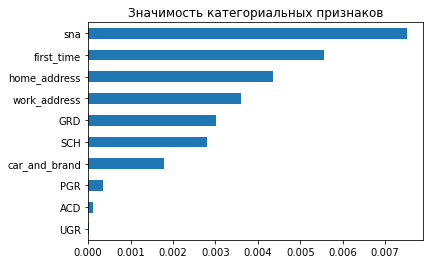

In [78]:
# Создаем новый перечень категориальных признаков для проверки
cat_cols_for_check = ['home_address', 'work_address',
                      'sna', 'first_time', 'car_and_brand']
# соединяем в одно целое преобразованный столбец education и столбец с новыми признаками
imp_cat = pd.Series(mutual_info_classif(pd.concat([df[cat_cols_for_check], dummies_edu], axis=1),
                                        df['default'], discrete_features=True),
                    # в качестве индексов берем названия столбцов
                    index=pd.concat([df[cat_cols_for_check], dummies_edu], axis=1).columns)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')
plt.title('Значимость категориальных признаков')

На графике видно, что большую роль играет то, как связан заемщик с клиентами банка и информация о самом заемщике (первый раз он обращается или нет). Также мы можем увидеть, что из столбца education наибольшую роль играют два типа образования:SCH и GRD. Теперь преобразуем категориальные признаки при помощи OneHotEncoding:

In [79]:
# преобразуем наши категориальные признаки при помощи OneHotEncoding
# для обучающей и тестовой выборок
df_cat = OneHotEncoder(sparse=False).fit_transform(df[cat_cols].values)
test_df_cat = OneHotEncoder(sparse=False).fit_transform(
    test_df[cat_cols].values)
# выведем результат
print(df_cat.shape)
print(test_df_cat.shape)

(73799, 22)
(36349, 22)


Посмотрим на наши дата-фреймы:

In [80]:
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,home_address,work_address,income,sna,first_time,foreign_passport,default,app_age,car_and_brand,income_level
0,25905,2014-02-01,SCH,1,4.143135,1,1,0.000000,0,-2.008753,...,1,2,9.798183,4,1,0,0,7.892826,2,0
1,63161,2014-03-12,SCH,0,4.094345,0,0,0.000000,0,-1.532276,...,2,3,9.852247,4,1,0,0,7.878155,0,0
2,25887,2014-02-01,SCH,1,3.258097,1,0,1.098612,0,-1.408142,...,1,2,10.308986,1,4,1,0,7.892826,1,0
3,16222,2014-01-23,SCH,0,3.988984,0,0,0.000000,0,-2.057471,...,2,3,9.210440,1,3,0,0,7.896181,0,0
4,101655,2014-04-18,GRD,1,3.891820,0,0,0.000000,1,-1.244723,...,2,3,10.308986,1,4,1,0,7.864036,0,0


In [81]:
test_df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,app_age,car_and_brand,income_level
0,74835,2014-03-22,GRD,1,3.401197,1,1,0.000000,0,-2.271884,...,50,1,2,10.819798,1,4,0,7.874359,2,1
1,17527,2014-01-24,SCH,0,3.688879,0,0,1.791759,0,-1.504999,...,50,1,2,8.517393,4,3,0,7.895808,0,0
2,75683,2014-03-23,UGR,1,3.931826,1,1,0.000000,0,-1.691339,...,50,1,2,10.308986,1,3,1,7.873978,2,0
3,26883,2014-02-03,SCH,1,4.043051,0,0,0.000000,0,-2.374182,...,40,1,2,9.741027,1,3,0,7.892078,0,0
4,28862,2014-02-04,GRD,0,3.663562,0,0,0.000000,0,-2.487502,...,80,2,3,11.695255,1,3,0,7.891705,0,1


Оба фрейма одинаковые, за исключением искомого столбца default. Теперь приступим к созданию и обучению модели.

# 4. Machine Learning

Далее будет проходить подготовка данных для обучения модели и непосредственно само обучение. Основной идеей является попытка рассмотреть несколько различных вариантов модели:
* обычная, на основе сформированных выше признаков
* нормализованная, на основе сформированных выше признаков
* нормализованная, с полиномиальными признаками
* нормализованная, с полиномиальными признаками и регуляризацией

## 4.1. Подготовка данных

### 4.1.1. Обычная модель

Объединим данные в одно пространство признаков и выделим target:

In [82]:
X_casual = np.hstack([df[num_cols].values, df[bin_cols].values, df_cat])
Y = df['default'].values

**Примечание**: Y мы объявим 1 раз, так как со значениями default мы не проводим никаких манипуляций

### 4.1.2. Нормализованная модель

Проведем нормализацию числовых признаков при помощи StandardScaler():

In [83]:
scaler = StandardScaler()
num_norm = scaler.fit_transform(df[num_cols].values)

Теперь, как и выше, объединим воедино все признаки:

In [84]:
X_norm = np.hstack([num_norm, df[bin_cols].values, df_cat])

### 4.1.3. Нормализованная модель с полиномиальными признаками

Сформируем полиномиальные признаки на основе имеющихся у нас числовых признаков:

In [85]:
poly = PolynomialFeatures(2)

num_poly = poly.fit_transform(df[num_cols].values)

Теперь нормализуем результат при помощи StandardScaler():

In [86]:
num_norm_poly = scaler.fit_transform(num_poly)

И снова объединим воедино признаки:

In [87]:
X_norm_poly = np.hstack([num_norm_poly, df[bin_cols].values, df_cat])

## 4.2. Обучение модели

Теперь необходимо проверить, какие результаты покажет каждая из выделенных моделей:

**Примечание:** Так как выборки у нас несбалансированные, применим параметр модели class_weight='balanced', который отвечает за балансировку классов

### 4.2.1. Обычная модель

Разделим обучающую выборку на тренировочную и валидационную:

In [88]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_casual, Y, test_size=0.30, random_state=RANDOM_SEED, shuffle=True)

Обучим модель:

In [89]:
lgr_casual = LogisticRegression(
    class_weight='balanced', random_state=RANDOM_SEED)
lgr_casual.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', random_state=45)

Теперь попробуем предсказать значения:

In [90]:
# Для тестовой выборки
probs_casual_tr = lgr_casual.predict_proba(X_train)
probs_casual_tr = probs_casual_tr[:, 1]
# Для валидационной выборки
probs_casual = lgr_casual.predict_proba(X_valid)
probs_casual = probs_casual[:, 1]
y_predict_c = lgr_casual.predict(X_valid)

Зафиксируем полученные значения для построения графика:

In [91]:
# значения для обучающей выборки
fpr_c_tr, tpr_c_tr, threshold_c_tr = roc_curve(y_train, probs_casual_tr)
roc_auc_c_tr = roc_auc_score(y_train, probs_casual_tr)
# значения для валидационной выборки
fpr_c, tpr_c, threshold_c = roc_curve(y_valid, probs_casual)
roc_auc_c = roc_auc_score(y_valid, probs_casual)

Построим график, чтобы увидеть как различаются предсказания на валидационной и тренировочной выборках:

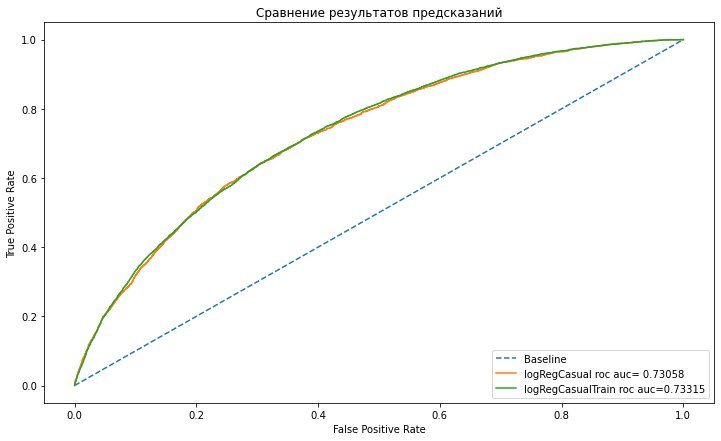

In [92]:
plt.figure(figsize=(12, 7))
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr_c, tpr_c, label='logRegCasual roc auc= %0.5f' % roc_auc_c)
plt.plot(fpr_c_tr, tpr_c_tr, label='logRegCasualTrain roc auc=%0.5f' %
         roc_auc_c_tr)
plt.title('Сравнение результатов предсказаний')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

Значения различаются не сильно, переобучения нет.

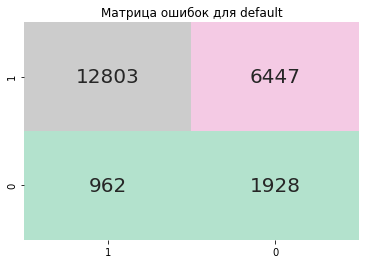

In [93]:
sns.heatmap(confusion_matrix(y_valid, y_predict_c), annot=True, annot_kws={"size": 20}, fmt='', cmap='Pastel2', cbar=False,
            xticklabels=['1', '0'], yticklabels=['1', '0'])
plt.title('Матрица ошибок для default')
plt.show()

### 4.2.2. Нормализованная модель

Общая логика здесь точно такая же, просто часть данных в выборке нормализована:

In [94]:
# разделим на тренировочную и тестовую выборки
X_train, X_valid, y_train, y_valid = train_test_split(
    X_norm, Y, test_size=0.30, random_state=RANDOM_SEED, shuffle=True)

In [95]:
# обучим модель
lgr_norm = LogisticRegression(
    class_weight='balanced', random_state=RANDOM_SEED)
lgr_norm.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', random_state=45)

In [96]:
# предскажем значения тренировочной выборки
probs_norm_tr = lgr_norm.predict_proba(X_train)
probs_norm_tr = probs_norm_tr[:, 1]
# предскажем значения валидационной выборки
probs_norm = lgr_norm.predict_proba(X_valid)
probs_norm = probs_norm[:, 1]
y_predict_n = lgr_norm.predict(X_valid)

In [97]:
# запомним параметры обучающей выборки
fpr_n_tr, tpr_n_tr, threshold_n_tr = roc_curve(y_train, probs_norm_tr)
roc_auc_n_tr = roc_auc_score(y_train, probs_norm_tr)
# запомним параметры валидационной выборки для построения кривой
fpr_n, tpr_n, threshold_n = roc_curve(y_valid, probs_norm)
roc_auc_n = roc_auc_score(y_valid, probs_norm)

Построим график для сравнения ROC AUC валидационной и тренировочной выборок:

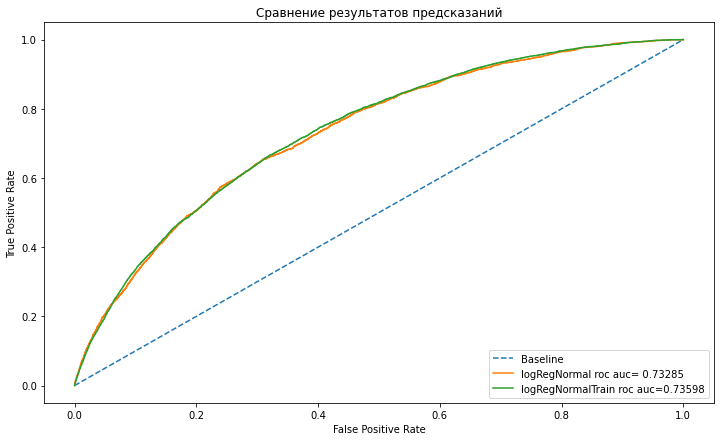

In [98]:
plt.figure(figsize=(12, 7))
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr_n, tpr_n, label='logRegNormal roc auc= %0.5f' % roc_auc_n)
plt.plot(fpr_n_tr, tpr_n_tr, label='logRegNormalTrain roc auc=%0.5f' %
         roc_auc_n_tr)
plt.title('Сравнение результатов предсказаний')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

Вывод схож с предудущим подпунктом - переобучения нет.

Построим матрицу ошибок валидационной выборки:

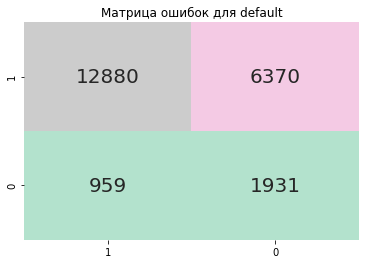

In [99]:
sns.heatmap(confusion_matrix(y_valid, y_predict_n), annot=True, annot_kws={"size": 20}, fmt='', cmap='Pastel2', cbar=False,
            xticklabels=['1', '0'], yticklabels=['1', '0'])
plt.title('Матрица ошибок для default')
plt.show()

### 4.2.3. Нормализованная модель с полиномиальными признаками

Далее аналогично п.п. 4.2.1 и 4.2.2

In [100]:
# разделим на тренировочную и тестовую выборки
X_train, X_valid, y_train, y_valid = train_test_split(
    X_norm_poly, Y, test_size=0.30, random_state=RANDOM_SEED, shuffle=True)

In [101]:
# обучим модель
lgr_norm_poly = LogisticRegression(
    class_weight='balanced', random_state=RANDOM_SEED)
lgr_norm_poly.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', random_state=45)

In [102]:
# предскажем значения тренировочной выборки
probs_norm_poly_tr = lgr_norm_poly.predict_proba(X_train)
probs_norm_poly_tr = probs_norm_poly_tr[:, 1]
# предскажем значения валидационной выборки
probs_norm_poly = lgr_norm_poly.predict_proba(X_valid)
probs_norm_poly = probs_norm_poly[:, 1]
y_predict_np = lgr_norm_poly.predict(X_valid)

In [103]:
# запомним параметры тренировочной выборки для построения кривой
fpr_np_tr, tpr_np_tr, threshold_np_tr = roc_curve(y_train, probs_norm_poly_tr)
roc_auc_np_tr = roc_auc_score(y_train, probs_norm_poly_tr)
# запомним параметры валидационной выборки для построения кривой
fpr_np, tpr_np, threshold_np = roc_curve(y_valid, probs_norm_poly)
roc_auc_np = roc_auc_score(y_valid, probs_norm_poly)

Построим графики ROC AUC для тренировочной и валидационной выборок:

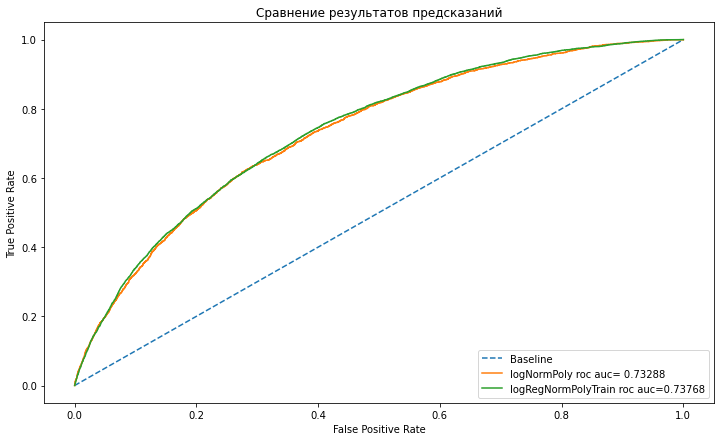

In [104]:
plt.figure(figsize=(12, 7))
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr_np, tpr_np, label='logNormPoly roc auc= %0.5f' % roc_auc_np)
plt.plot(fpr_np_tr, tpr_np_tr,
         label='logRegNormPolyTrain roc auc=%0.5f' % roc_auc_np_tr)
plt.title('Сравнение результатов предсказаний')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

Как и в предыдущих моделях - переобучения нет, кривые почти идентичны

Построим матрицу ошибок для валидационной выборки:

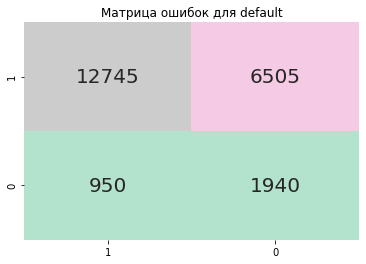

In [105]:
sns.heatmap(confusion_matrix(y_valid, y_predict_np), annot=True, annot_kws={"size": 20}, fmt='', cmap='Pastel2', cbar=False,
            xticklabels=['1', '0'], yticklabels=['1', '0'])
plt.title('Матрица ошибок для default')
plt.show()

### 4.2.4. Нормализованная модель с полиномиальными признаками и регуляризацией

Первая часть идет аналогично п. 4.2.3:

In [106]:
# разделим на тренировочную и тестовую выборки
X_train, X_valid, y_train, y_valid = train_test_split(
    X_norm_poly, Y, test_size=0.30, random_state=RANDOM_SEED, shuffle=True)

Теперь приступим к самой регуляризации:

In [107]:
# зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)
# укажем типы регуляризации
penalty = ['l1', 'l2']
# создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)
model = LogisticRegression(random_state=RANDOM_SEED)
model.fit(X_train, y_train)
# укажем сетку поиска с использованием пятикратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)
# Выведем лучшие гиперпараметры
print('Лучший penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучший penalty: l2
Лучшее C: 1291.5496650148827


Теперь обучим модель с использованием получившихся значений:

In [108]:
lgr_hyp = LogisticRegression(
    penalty='l2', C=1291.5496650148827, class_weight='balanced', random_state=RANDOM_SEED)
lgr_hyp.fit(X_train, y_train)

LogisticRegression(C=1291.5496650148827, class_weight='balanced',
                   random_state=45)

In [109]:
# предскажем значения тренировочной выборки
probs_hyp_tr = lgr_hyp.predict_proba(X_train)
probs_hyp_tr = probs_hyp_tr[:, 1]
# предскажем значения валидационной выборки
probs_hyp = lgr_hyp.predict_proba(X_valid)
probs_hyp = probs_hyp[:, 1]
y_predict_hyp = lgr_hyp.predict(X_valid)

In [110]:
# запомним параметры тренировочной выборки для построения кривой
fpr_hyp_tr, tpr_hyp_tr, threshold_hyp_tr = roc_curve(y_train, probs_hyp_tr)
roc_auc_hyp_tr = roc_auc_score(y_train, probs_hyp_tr)
# запомним параметры валидационной выборки для построения кривой
fpr_hyp, tpr_hyp, threshold_hyp = roc_curve(y_valid, probs_hyp)
roc_auc_hyp = roc_auc_score(y_valid, probs_hyp)

Построим графики ROC AUC для тренировочной и валидационной выборок:

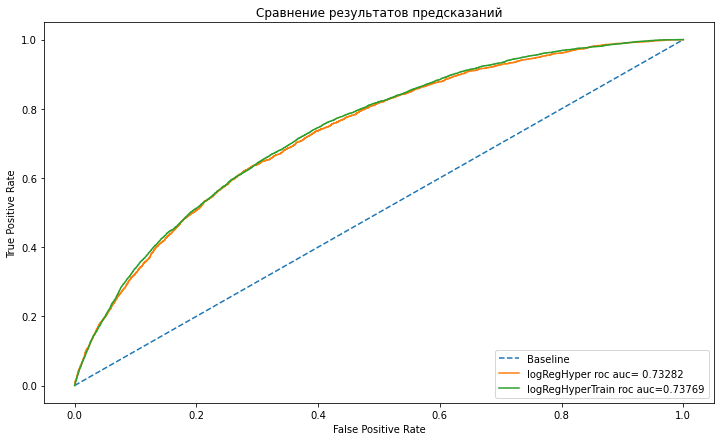

In [111]:
plt.figure(figsize=(12, 7))
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr_hyp, tpr_hyp, label='logRegHyper roc auc= %0.5f' % roc_auc_hyp)
plt.plot(fpr_hyp_tr, tpr_hyp_tr,
         label='logRegHyperTrain roc auc=%0.5f' % roc_auc_hyp_tr)
plt.title('Сравнение результатов предсказаний')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

И снова, кривые почти идентичны - переобучения нет.

Построим матрицу ошибок для валидационной выборки:

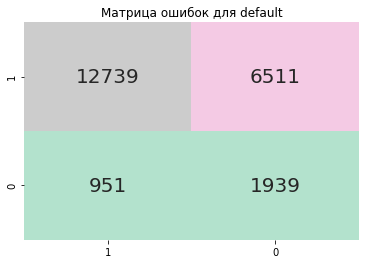

In [112]:
sns.heatmap(confusion_matrix(y_valid, y_predict_hyp), annot=True, annot_kws={"size": 20}, fmt='', cmap='Pastel2', cbar=False,
            xticklabels=['1', '0'], yticklabels=['1', '0'])
plt.title('Матрица ошибок для default')
plt.show()

### 4.2.5. Результаты

Построим график, который будет отражать полученные нами данные:

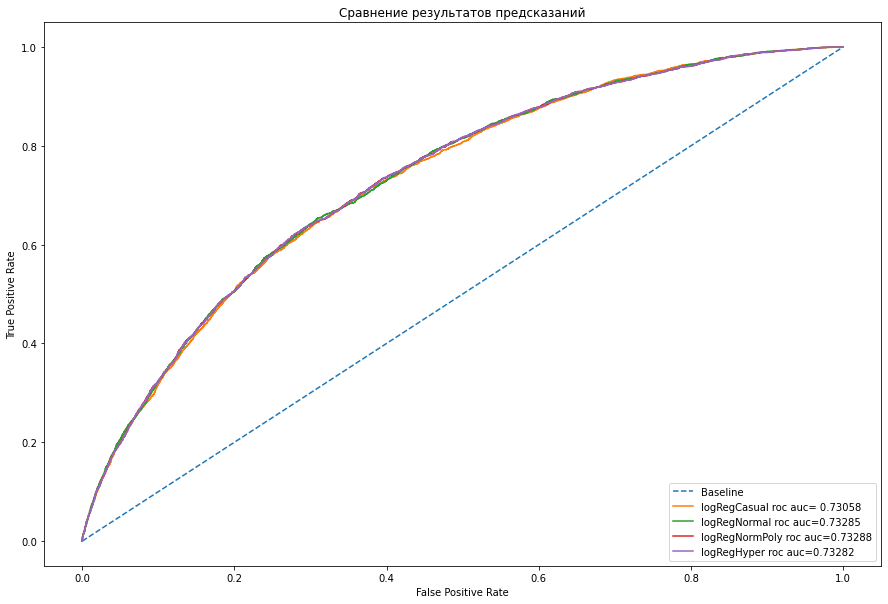

In [113]:
plt.figure(figsize=(15, 10))
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr_c, tpr_c, label='logRegCasual roc auc= %0.5f' % roc_auc_c)
plt.plot(fpr_n, tpr_n, label='logRegNormal roc auc=%0.5f' % roc_auc_n)
plt.plot(fpr_np, tpr_np, label='logRegNormPoly roc auc=%0.5f' % roc_auc_np)
plt.plot(fpr_hyp, tpr_hyp, label='logRegHyper roc auc=%0.5f' % roc_auc_hyp)
plt.title('Сравнение результатов предсказаний')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

Как можно увидеть - почти все кривые различаются совсем незначительно, метрика roc_auc почти везде раличается только после 4 знака. При этом, точность предсказания дефолтного клиента гораздо выше чем у "случайного" способа определения. Для использования на тестовой выборке выберем модель с регуляризацией.

# 5. Submission

Теперь перейдем к тестовому дата-фрейму. Предварительно, сделаем нормализацию и выделим полиномиальные признаки, при этом используем transform, чтобы для нормализации применились значения обучающей выборки. Для начала выделим полиномиальные признаки:

In [114]:
X_poly_t = poly.fit_transform(test_df[num_cols].values)

Теперь используем StandardScaler:

In [115]:
X_norm_poly_t = scaler.transform(X_poly_t)

Объединим воедино поле признаков тестового фрейма:

In [116]:
X_test = np.hstack([X_norm_poly_t, test_df[bin_cols].values, test_df_cat])

Обучим модель на всей выборке:

In [117]:
# Запишем значения default в y_tr для обучения
Y_tr = df['default'].values
# Обучим саму модель:
test_model = LogisticRegression(
    penalty='l2', C=1291.5496650148827, class_weight='balanced', random_state=RANDOM_SEED)
test_model.fit(X_norm_poly, Y_tr)

LogisticRegression(C=1291.5496650148827, class_weight='balanced',
                   random_state=45)

Теперь сделаем предсказание для тестовой выборки:

In [118]:
y_test_pred = test_model.predict(X_test)
y_pred_prob_test = test_model.predict_proba(X_test)[:, 1]

Сформируем сабмит:

In [119]:
submission = pd.DataFrame(
    {'client_id': test_df.client_id, "default": y_pred_prob_test})
submission.to_csv('submission.csv', index=False)
submission.head()

,client_id,default
0,74835,0.215277
1,17527,0.824939
2,75683,0.329621
3,26883,0.368337
4,28862,0.107692


**Вывод**: Мы получили модель с метрикой ROG AUC примерно 0.73, что уже является хорошим показателем. Для дальнейшего усовершенствования модели может быть необходимо создать новые признаки или придумать какие-либо решения со значениями, которые вызывают сомнение в рамках IQR.